In [1]:
import os
import sys
import shutil
import pathlib
from joblib import parallel_backend
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize

from nilearn import  maskers
import nibabel as nib

from neuroquery import datasets
from neuroquery.img_utils import coordinates_to_maps
from neuroquery.smoothed_regression import SmoothedRegression
from neuroquery.tokenization import TextVectorizer
from neuroquery.encoding import NeuroQueryModel

import torch
from torch import nn

from neurovlm.loss import compute_metrics
from neurovlm.models import ProjHead, Specter
from neurovlm.train import Trainer
from neurovlm.data import get_data_dir
neurovlm_data_dir = get_data_dir()

#sys.path.append('/home/jerjes/repos/neurovlm/src/neurovlm')
sys.path.append('/Users/ryanhammonds/projects/neurovlm')

## load

In [2]:
# Load NeuroQuery data
data_dir = pathlib.Path(datasets.fetch_neuroquery_model())
corpus_metadata = pd.read_csv(str(data_dir / "corpus_metadata.csv"))
vectorizer = TextVectorizer.from_vocabulary_file(str(data_dir / "vocabulary.csv"))
tfidf = sparse.load_npz(str(data_dir / "corpus_tfidf.npz"))
coordinates = pd.read_csv(datasets.fetch_peak_coordinates())
print(f"Loaded {corpus_metadata.shape[0]} studies")

Loaded 13459 studies


In [ ]:
# # Run process_coords.py for a parallel version (2+ hours vs 5 minutes)
# mask_img = nib.load(str(data_dir / "mask_img.nii.gz"))
# mask_data = mask_img.get_fdata().astype(np.float32, copy=False)
# mask_img = nib.Nifti1Image(mask_data, affine=mask_img.affine, header=mask_img.header)
# brain_maps, masker = coordinates_to_maps(
#     coordinates, mask_img=mask_img, target_affine=(4, 4, 4), fwhm=9.0
# )
# brain_maps = brain_maps[(brain_maps.values != 0).any(axis=1)]
# brain_maps.to_parquet(neurovlm_data_dir / "brain_maps.parquet")

In [3]:
# Load publications df
pmids = corpus_metadata["pmid"]
neurovlm_dir = get_data_dir()
publications_df = pd.read_parquet(neurovlm_dir / "publications_more.parquet")

# Concat title + abstract
publications_matched = publications_df[publications_df['pmid'].isin(pmids)].copy()
publications_matched = publications_matched.set_index('pmid').loc[pmids].reset_index()

def create_query_text(row):
    name = str(row['name']) if pd.notna(row['name']) else ""
    description = str(row['description']) if pd.notna(row['description']) else ""
    if name and description:
        return f"{name} [SEP] {description}"
    elif name:
        return name
    else:
        return ""

publications_matched['query_text'] = publications_matched.apply(create_query_text, axis=1)
corpus_metadata.rename(columns={"index": "pmid"}, inplace=True)
corpus_metadata = corpus_metadata.set_index("pmid").reset_index()

# Load neurovlm data and model
neurovlm_data_dir = get_data_dir()

autoencoder = torch.load(neurovlm_data_dir / "autoencoder.pt", weights_only=False)
decoder = autoencoder.decoder.to("cpu")# Load your trained projection head

neuro_vectors = torch.load(neurovlm_data_dir / "neuro_vectors.pt")
neuro_vectors = neuro_vectors[np.array(publications_df['pmid'].isin(pmids))]

mask_arrays = np.load(f"{neurovlm_data_dir}/mask.npz", allow_pickle=True)
masker_4mm = maskers.NiftiMasker(
    mask_img=nib.Nifti1Image(mask_arrays["mask"].astype(float),  mask_arrays["affine"]),
    dtype=np.float32
).fit()

# Keep only neuroquery ids
neuro_vectors = torch.load(neurovlm_data_dir / "neuro_vectors.pt")
mask = torch.tensor(np.array(publications_df["pmid"].isin(pmids).values))
neuro_vectors = neuro_vectors[mask]

neuro_vectors_bin = neuro_vectors.clone()
neuro_vectors_bin[neuro_vectors_bin > 0.001] = 1.
neuro_vectors_bin[neuro_vectors_bin <= 0.001] = 0.

## neuroquery

In [ ]:
os.makedirs(data_dir / "decoder", exist_ok=True)

kf = KFold(n_splits=10, shuffle=True, random_state=0)

neuro_vectors_arr = neuro_vectors.numpy()
neuro_vectors_bin_arr = neuro_vectors_bin.numpy()
for i, (train_inds, test_inds) in enumerate(kf.split(range(len(neuro_vectors_arr)))):

    # Neuroquery
    regressor = SmoothedRegression(alphas=np.array([1.0, 10.0, 100.0]))
    with parallel_backend('loky', n_jobs=10):
        _ = regressor.fit(tfidf[train_inds], neuro_vectors_arr[train_inds])

    regressor_bin = SmoothedRegression(alphas=np.array([1.0, 10.0, 100.0]))
    with parallel_backend('loky', n_jobs=10):
        _ = regressor_bin.fit(tfidf[train_inds], neuro_vectors_bin_arr[train_inds])

    nqm = NeuroQueryModel(
        vectorizer,
        regressor,
        masker_4mm.mask_img,
        corpus_info={
            "tfidf": sparse.csr_matrix(tfidf[train_inds]),
            "metadata": corpus_metadata.iloc[train_inds],
        },
    )

    nqm_bin = NeuroQueryModel(
        vectorizer,
        regressor_bin,
        masker_4mm.mask_img,
        corpus_info={
            "tfidf": sparse.csr_matrix(tfidf[train_inds]),
            "metadata": corpus_metadata.iloc[train_inds],
        },
    )

    out = data_dir / "neuroquery" / f"model_fold{str(i).zfill(2)}"
    out_bin = data_dir / "neuroquery" / f"model_bin_fold{str(i).zfill(2)}"

    if out.exists():
        shutil.rmtree(out)
    if out_bin.exists():
        shutil.rmtree(out_bin)

    nqm.to_data_dir(out)
    nqm_bin.to_data_dir(out_bin)

keeping 273 features
keeping 217 features
keeping 272 features
keeping 225 features
keeping 271 features
keeping 217 features
keeping 257 features
keeping 216 features
keeping 264 features
keeping 215 features
keeping 266 features
keeping 220 features
keeping 262 features
keeping 221 features
keeping 279 features
keeping 222 features
keeping 272 features
keeping 227 features
keeping 263 features
keeping 204 features


## neurovlm

In [4]:
# Load encoded text, stack encodings from various specter adapters
latent_text_proxi, pmids = torch.load(neurovlm_data_dir / "latent_specter2_proxi.pt", weights_only=False).values()
latent_text_neuro, pmids = torch.load(neurovlm_data_dir / "latent_specter2_neuro.pt", weights_only=False).values()
latent_text_adhoc, pmids = torch.load(neurovlm_data_dir / "latent_specter2_adhoc.pt", weights_only=False).values()

# Load encoded neurovecotrs from the second notebook
latent_neuro = torch.load(neurovlm_data_dir / "latent_neuro.pt")

# Mask to select neuroquery ids
mask = pd.Series(pmids).isin(corpus_metadata["pmid"])
latent_text_adhoc = latent_text_adhoc[mask]
latent_text_neuro = latent_text_neuro[mask]
latent_text_proxi = latent_text_proxi[mask]
latent_neuro = latent_neuro[mask]
latent_text = torch.column_stack((latent_text_adhoc, latent_text_neuro, latent_text_proxi))

In [6]:
from torch import nn

os.makedirs(neurovlm_data_dir / "proj_head_cv", exist_ok=True)

kf = KFold(n_splits=10, shuffle=True, random_state=0)

for i, (train_inds, test_inds) in enumerate(kf.split(range(len(neuro_vectors)))):

    np.random.shuffle(train_inds)
    val_inds = train_inds[:1000]
    train_inds = train_inds[1000:]

    dim = 768
    proj_head = ProjHead(seed=123, latent_text_dim=int(dim*3), hidden_dim=int(dim*2), latent_neuro_dim=dim//2)

    trainer = Trainer(
        proj_head,
        batch_size=512,
        n_epochs=250,
        lr=5e-5,
        loss_fn=nn.MSELoss(),
        optimizer=torch.optim.AdamW,
        device="auto",
        interval=20,
        X_val=latent_text[val_inds],
        y_val=latent_neuro[val_inds]
    )

    trainer.fit(
        latent_text[train_inds],
        latent_neuro[train_inds]
    )

    trainer.restore_best()

    proj_head = trainer.model

    # Save
    trainer.save(neurovlm_data_dir / "proj_head_cv" / f"proj_head_mse_{str(i).zfill(2)}.pt")

Epoch: -1, val loss: 1.0678
Epoch: 0, val loss: 0.98917
Epoch: 20, val loss: 0.68123
Epoch: 40, val loss: 0.66658
Epoch: 60, val loss: 0.65973
Epoch: 80, val loss: 0.65561
Epoch: 100, val loss: 0.65091
Epoch: 120, val loss: 0.64881
Epoch: 140, val loss: 0.64698
Epoch: 160, val loss: 0.64651
Epoch: 180, val loss: 0.6458
Epoch: 200, val loss: 0.64604
Epoch: 220, val loss: 0.64665
Epoch: 240, val loss: 0.64625
Epoch: -1, val loss: 1.0532
Epoch: 0, val loss: 0.97617
Epoch: 20, val loss: 0.6782
Epoch: 40, val loss: 0.66103
Epoch: 60, val loss: 0.65289
Epoch: 80, val loss: 0.6483
Epoch: 100, val loss: 0.64475
Epoch: 120, val loss: 0.64253
Epoch: 140, val loss: 0.64114
Epoch: 160, val loss: 0.6405
Epoch: 180, val loss: 0.64035
Epoch: 200, val loss: 0.63966
Epoch: 220, val loss: 0.63991
Epoch: 240, val loss: 0.64058
Epoch: -1, val loss: 1.0884
Epoch: 0, val loss: 1.009
Epoch: 20, val loss: 0.69183
Epoch: 40, val loss: 0.67387
Epoch: 60, val loss: 0.66718
Epoch: 80, val loss: 0.66274
Epoch: 100

## decoding

In [6]:
os.makedirs(neurovlm_data_dir / "proj_head_cv", exist_ok=True)

kf = KFold(n_splits=10, shuffle=True, random_state=0)

for isplit, (train_inds, test_inds) in enumerate(kf.split(range(len(neuro_vectors)))):

    # neuroquery, binary targets
    vec_pred_neuroquery = np.zeros((len(test_inds), 28542))
    nqm = NeuroQueryModel.from_data_dir(data_dir / "neuroquery" / f"model_bin_fold{str(isplit).zfill(2)}")

    nqm.smoothed_regression.regression_.intercept_ = 0.0

    for i in tqdm(range(len(test_inds)), total=len(test_inds)):
        raw_tfidf = nqm.vectorizer.transform([publications_matched.iloc[test_inds[i]]["query_text"]])
        raw_tfidf = normalize(raw_tfidf, copy=False)
        vec_pred_neuroquery[i] = nqm.smoothed_regression.transform_to_brain_maps(raw_tfidf)[0]

    np.save(neurovlm_data_dir / "decoder" / f"vec_pred_neuroquery_bin{str(isplit).zfill(2)}", vec_pred_neuroquery)

    # neuroquery, continuous targets
    vec_pred_neuroquery = np.zeros((len(test_inds), 28542))
    nqm = NeuroQueryModel.from_data_dir(data_dir / "neuroquery" / f"model_fold{str(isplit).zfill(2)}")

    nqm.smoothed_regression.regression_.intercept_ = 0.0

    for i in tqdm(range(len(test_inds)), total=len(test_inds)):
        raw_tfidf = nqm.vectorizer.transform([publications_matched.iloc[test_inds[i]]["query_text"]])
        raw_tfidf = normalize(raw_tfidf, copy=False)
        vec_pred_neuroquery[i] = nqm.smoothed_regression.transform_to_brain_maps(raw_tfidf)[0]

    np.save(neurovlm_data_dir / "decoder" / f"vec_pred_neuroquery_{str(isplit).zfill(2)}", vec_pred_neuroquery)

    # neurovlm, binary targets
    proj_head = torch.load(
        neurovlm_data_dir / "proj_head_cv" / f"proj_head_mse_{str(isplit).zfill(2)}.pt",
        weights_only=False
    ).eval().cpu()

    vec_pred_neurovlm = torch.sigmoid(decoder(proj_head(latent_text[test_inds]))).detach().numpy()

    np.save(neurovlm_data_dir / "decoder" / f"vec_pred_neurovlm_{str(isplit).zfill(2)}", vec_pred_neurovlm)

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1346 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

  0%|          | 0/1345 [00:00<?, ?it/s]

In [5]:
neuro_vectors = neuro_vectors.numpy()
neuro_vectors_bin = neuro_vectors_bin.numpy()

In [18]:
logloss_fn = nn.CrossEntropyLoss()
thresholds = np.linspace(0, 1, 21)[:-1] * 100

kf = KFold(n_splits=10, shuffle=True, random_state=0)

results = {}

for method in ["neuroquery", "neurovlm"]:

    results[method] = {}

    for target in ["binary", "continuous"]:

        results[method][target] = {}
        results[method][target]["mse"] = []
        results[method][target]["dice"] = []
        results[method][target]["ssim"] = []
        results[method][target]["r"] = []
        results[method][target]["logloss"] = []

        for isplit, (train_inds, test_inds) in tqdm(enumerate(kf.split(range(len(neuro_vectors)))), total=10):

            # Metrics
            mse = np.zeros((len(test_inds), len(thresholds)))
            dice = np.zeros((len(test_inds), len(thresholds)))
            ssim = np.zeros((len(test_inds), len(thresholds)))
            r = np.zeros(len(test_inds))
            logloss = np.zeros(len(test_inds))

            # Predictions
            if method == "neuroquery" and target == "continuous":
                vec_pred = np.load(neurovlm_data_dir / "decoder" / f"vec_pred_neuroquery_{str(isplit).zfill(2)}.npy")
            elif method == "neuroquery" and target == "binary":
                vec_pred = np.load(neurovlm_data_dir / "decoder" / f"vec_pred_neuroquery_bin{str(isplit).zfill(2)}.npy")
            elif method == "neurovlm":
                vec_pred = np.load(neurovlm_data_dir / "decoder" / f"vec_pred_neurovlm_{str(isplit).zfill(2)}.npy")

            # True targets
            if target == "continuous":
                vec_true = neuro_vectors
            else:
                vec_true = neuro_vectors_bin

            # Performance
            for i in range(len(test_inds)):

                mse[i], dice[i], ssim[i] = compute_metrics(
                    vec_true[test_inds[i]], vec_pred[i],
                    thresholds=thresholds, percentile=True
                )

                r[i] = np.corrcoef(vec_true[test_inds[i]], vec_pred[i])[0][1]

                logloss[i] = logloss_fn(torch.from_numpy(vec_pred[i]),
                                        torch.from_numpy(vec_true[test_inds[i]]))

            results[method][target]["mse"].append(mse)
            results[method][target]["dice"].append(dice)
            results[method][target]["ssim"].append(ssim)
            results[method][target]["r"].append(r)
            results[method][target]["logloss"].append(logloss)

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/ryanhammonds/projects/neurovlm/back_gh/neurovlm/.env/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ryanhammonds/projects/neurovlm/back_gh/neurovlm/.env/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

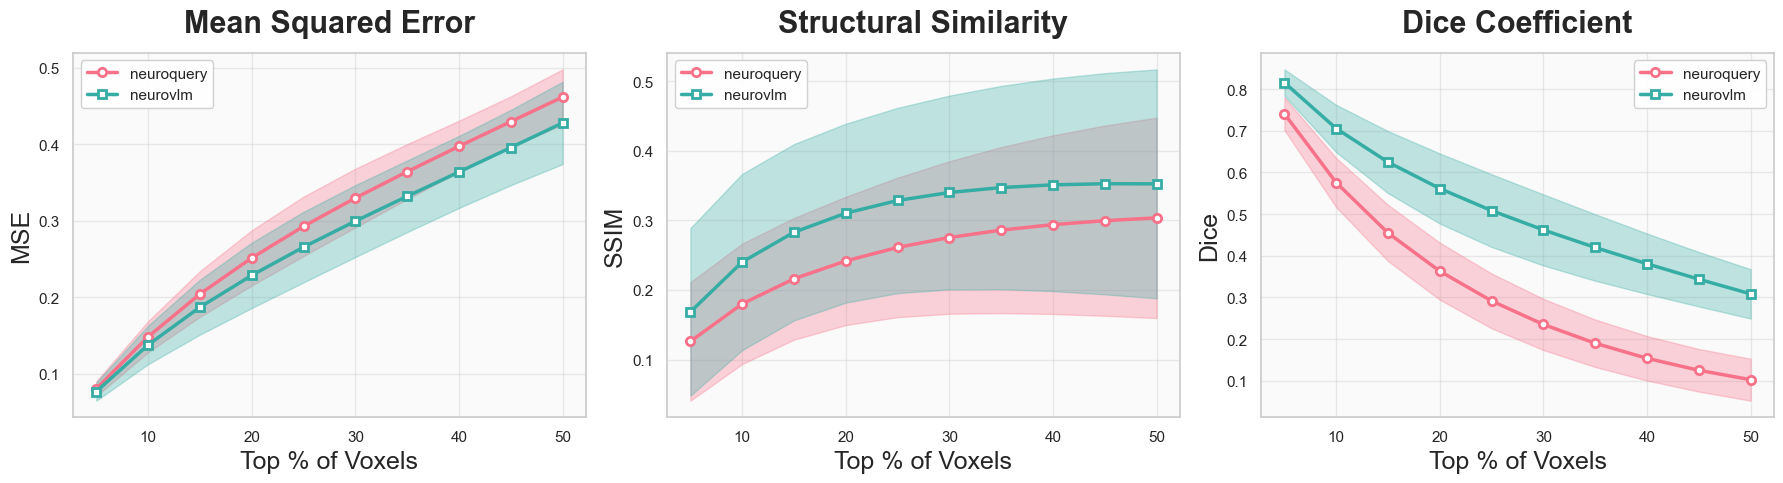

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set modern seaborn style for nice plots
sns.set_style("whitegrid")
sns.set_context("notebook")
colors = sns.color_palette("husl", 2)

thresholds = np.linspace(0, 1, 21)[:-1] * 100
mask = thresholds >= 50

# Helper function to compute mean/std
def summarize(arr):
    return arr.mean(axis=0), arr.std(axis=0)

# Summarize metrics
nq = results["neuroquery"]["continuous"]
nv = results["neurovlm"]["continuous"]
mse_di_mean, mse_di_std = summarize(np.concatenate(nq["mse"]))
mse_ae_mean, mse_ae_std = summarize(np.concatenate(nv["mse"]))
ssim_di_mean, ssim_di_std = summarize(np.concatenate(nq["ssim"]))
ssim_ae_mean, ssim_ae_std = summarize(np.concatenate(nv["ssim"]))
dice_di_mean, dice_di_std = summarize(np.concatenate(nq["dice"]))
dice_ae_mean, dice_ae_std = summarize(np.concatenate(nv["dice"]))

r_nq_flat = np.concatenate(nq["r"])
r_nv_flat = np.concatenate(nv["r"])
r_nq_flat[np.isnan(r_nq_flat)] = 0.

# Create horizontal subplot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Styled function to plot mean/std curves
def plot_metric(ax, thresholds, di_mean, di_std, ae_mean, ae_std, title, ylabel):
    # Plot lines with markers
    ax.plot(100-thresholds[mask], di_mean[mask], label="neuroquery", color=colors[0],
            linewidth=2.5, marker='o', markersize=6, markerfacecolor='white',
            markeredgewidth=2, markeredgecolor=colors[0])
    ax.fill_between(100-thresholds[mask], (di_mean - di_std)[mask], (di_mean + di_std)[mask],
                    alpha=0.3, color=colors[0])

    ax.plot(100-thresholds[mask], ae_mean[mask], label="neurovlm", color=colors[1],
            linewidth=2.5, marker='s', markersize=6, markerfacecolor='white',
            markeredgewidth=2, markeredgecolor=colors[1])
    ax.fill_between(100-thresholds[mask], (ae_mean - ae_std)[mask], (ae_mean + ae_std)[mask],
                    alpha=0.3, color=colors[1])

    # Styling
    ax.set_title(f'{title}', fontsize=22, fontweight='bold', pad=15)
    ax.set_xlabel('Top % of Voxels', fontsize=18, fontweight='medium')
    ax.set_ylabel(ylabel, fontsize=18, fontweight='medium')
    ax.legend(frameon=True, fancybox=True, shadow=False, framealpha=0.9)
    ax.grid(True, alpha=0.4)
    ax.set_xticks(100-np.arange(50, 91, 10))
    ax.set_facecolor('#fafafa')

# Plot first three metrics with line + shaded std
plot_metric(axes[0], thresholds, mse_di_mean, mse_di_std, mse_ae_mean, mse_ae_std,
           "Mean Squared Error", "MSE")
plot_metric(axes[1], thresholds, ssim_di_mean, ssim_di_std, ssim_ae_mean, ssim_ae_std,
           "Structural Similarity", "SSIM")
plot_metric(axes[2], thresholds, dice_di_mean, dice_di_std, dice_ae_mean, dice_ae_std,
           "Dice Coefficient", "Dice")

# Last subplot: styled boxplot for R
# box_plot = axes[3].boxplot([r_nq_flat, r_nv_flat],
#                           tick_labels=["neuroquery", "neurovlm"],
#                           patch_artist=True,
#                           boxprops=dict(facecolor='lightblue', alpha=0.7),
#                           medianprops=dict(color='red', linewidth=2),
#                           whiskerprops=dict(linewidth=1.5),
#                           capprops=dict(linewidth=1.5),
#                           #showfliers=False,
#                           flierprops=dict(marker='o', markerfacecolor='red',
#                                           markersize=4, alpha=0.6))

# # Color the boxes with consistent colors
# for patch, color in zip(box_plot['boxes'], colors):
#     patch.set_facecolor(color)
#     patch.set_alpha(0.7)

# axes[3].set_title("Correlation", fontsize=22, fontweight='bold', pad=15)
# # axes[3].set_xlabel('Method', fontsize=13, fontweight='medium')
# axes[3].set_ylabel('R', fontsize=18, fontweight='medium')
# axes[3].grid(True, alpha=0.4)
# axes[3].tick_params(axis='both', which='major', labelsize=11)
# axes[3].set_facecolor('#fafafa')
# axes[3].tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.savefig(get_data_dir() / "neurovlm_vs_neuroquery.png")